# Updated Baseline
The code and results below correspond to an upgraded baseline upon the Landslide4Sense dataset. The actual baseline suggested by the dataset was 56% in F1 and 76% in MLou. Here, I replicated the baseline and added my own touches to see how it affects our results.

## Initial Setup and Tests
General focus here is to just get a feel of the data, its dimensions and how we can use for eventual training. Below are cells that:


*   Mount our drive (where the data is located) and initalizes paths.
*   pip install and import all required packages for our baseline.



In [1]:
# install and configure
!pip install --quiet kaggle
from google.colab import files
files.upload()                         # upload kaggle.json
!mkdir -p ~/.kaggle
!mv kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

!kaggle datasets download tekbahadurkshetri/landslide4sense \
-p /content/landslide_data --unzip


Saving kaggle.json to kaggle.json
Dataset URL: https://www.kaggle.com/datasets/tekbahadurkshetri/landslide4sense
License(s): other
100% 2.85G/2.85G [00:12<00:00, 522MB/s]
100% 2.85G/2.85G [00:12<00:00, 249MB/s]


In [2]:
BASE_PATH = "/content"
DATA_PATH = f"{BASE_PATH}/landslide_data"

In [3]:
!pip install pandas numpy torch torchvision torchaudio h5py -q
!pip install opencv-python matplotlib segmentation-models-pytorch albumentations tqdm -q

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 3.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 119.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 97.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 55.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 4.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 42.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 18.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 4.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 188.7/188.7 MB 6.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 105.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 154.8/154.8 kB 13.4 MB/s eta 0:00:00


In [4]:
import torch
import numpy as np
import os
import cv2
import matplotlib as plt
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, utils
import segmentation_models_pytorch as smp
import albumentations as A
from albumentations.pytorch import ToTensorV2
from tqdm import tqdm
import h5py

## Data and loading Dataset class
This Section focuses on initializing our .h5 image data. I went through several resources to understand this datatype.

In [5]:
# Test Data and check type, verified it here.

sample_path = f"{DATA_PATH}/TrainData/img/image_1.h5"  # adjust this to match one of your file names

with h5py.File(sample_path, 'r') as f:
    print(list(f.keys()))  # shows all datasets inside the file
    data = f['img'][:]   # try reading the image data (dataset name might be different, we’ll check)
    print("Data shape:", data.shape)

mask_path = f"{DATA_PATH}/TrainData/mask/mask_1.h5"

with h5py.File(mask_path, 'r') as f:
    print(f.keys())  # find correct key
    mask = f['mask'][:]  # or whatever the key is
    print("Mask shape:", mask.shape)
    print("Unique values:", np.unique(mask))


['img']
Data shape: (128, 128, 14)
<KeysViewHDF5 ['mask']>
Mask shape: (128, 128)
Unique values: [0 1]


In [6]:
import torch
from torch.utils.data import Dataset, DataLoader
import numpy as np
import h5py
import cv2
import albumentations as A
from albumentations.pytorch import ToTensorV2

# 1) Band‑engineering function
def compute_26_bands(raw):
    """
    raw: np.ndarray of shape (14, H, W)
    returns: np.ndarray of shape (26, H, W)
    """
    B2, B3, B4 = raw[1], raw[2], raw[3]
    B8, B11, B12 = raw[7], raw[10], raw[11]

    # Normalize B2, B3, B4
    def norm(b): return (b - b.min())/(b.max() - b.min() + 1e-8)
    B2n, B3n, B4n = norm(B2), norm(B3), norm(B4)

    # Spectral indices
    ndvi = (B8 - B4) / (B8 + B4 + 1e-8)
    ndmi = (B8 - B11) / (B8 + B11 + 1e-8)
    nbr  = (B8 - B12) / (B8 + B12 + 1e-8)

    # Grayscale
    gray = (B2 + B3 + B4) / 3.0

    # Smoothing (odd kernels)
    gauss  = cv2.GaussianBlur(gray,  (11, 11), 0)
    median = cv2.medianBlur((gray*255).astype(np.uint8), 11) / 255.0

    # Gradients
    gradx = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=3)
    grady = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=3)

    # Edge map
    canny = cv2.Canny((gray*255).astype(np.uint8), 100, 200) / 255.0

    # Stack extras as (1, H, W)
    extras = [e[np.newaxis, ...] for e in [
        B2n, B3n, B4n,
        ndvi, ndmi, nbr,
        gray, gauss, median,
        gradx, grady, canny
    ]]

    return np.concatenate([raw] + extras, axis=0)


# 2) Dataset class
class LandSlideHSDataset(Dataset):
    def __init__(self, img_paths, mask_paths, transform=None):
        self.img_paths  = img_paths
        self.mask_paths = mask_paths
        self.transform  = transform

    def __len__(self):
        return len(self.img_paths)

    def __getitem__(self, idx):
        # Load raw 14-band image (H, W, 14)
        with h5py.File(self.img_paths[idx], 'r') as f:
            raw14 = f['img'][:]             # NumPy (H, W, 14)

        # Compute 26 bands
        raw14_chw = np.transpose(raw14, (2, 0, 1))  # (14, H, W)
        full26_chw = compute_26_bands(raw14_chw)[:23]    # (26, H, W)
        img = np.transpose(full26_chw, (1, 2, 0))   # (H, W, 26)

        # Load mask (H, W)
        with h5py.File(self.mask_paths[idx], 'r') as f:
            mask = f['mask'][:]                   # NumPy (H, W)

        # Apply Albumentations transforms
        if self.transform:
            aug = self.transform(image=img, mask=mask)
            img, mask = aug['image'], aug['mask']

        # img is now Tensor (C=26, H, W); mask is Tensor (H, W)
        img_tensor  = img.float()
        mask_tensor = mask.unsqueeze(0).float()     # add channel dim → (1, H, W)

        return img_tensor, mask_tensor


# 3) Define transforms
train_transform = A.Compose([
    A.Resize(256, 256),
    A.HorizontalFlip(p=0.5),
    A.RandomRotate90(p=0.5),
    ToTensorV2(),
])

val_transform = A.Compose([
    A.Resize(256, 256),
    ToTensorV2(),
])

# 4) Instantiate & test
DATA_PATH = f"{BASE_PATH}/landslide_data"
ds = LandSlideHSDataset(
    img_paths=[
        f"{DATA_PATH}/TrainData/img/image_1.h5",
        f"{DATA_PATH}/TrainData/img/image_2.h5",
    ],
    mask_paths=[
        f"{DATA_PATH}/TrainData/mask/mask_1.h5",
        f"{DATA_PATH}/TrainData/mask/mask_2.h5",
    ],
    transform=train_transform
)
print("Dataset length:", len(ds))
img_tensor, mask_tensor = ds[0]
print("Image tensor shape:", img_tensor.shape)  # expect (26, 128, 128)
print("Mask tensor shape: ", mask_tensor.shape) # expect (1, 128, 128)

Dataset length: 2
Image tensor shape: torch.Size([23, 256, 256])
Mask tensor shape:  torch.Size([1, 256, 256])


In [7]:
# Use Dataloaders and split the Training data into a 80/20 Split.

img_dir  = f"{DATA_PATH}/TrainData/img"
mask_dir = f"{DATA_PATH}/TrainData/mask"

all_img_paths = sorted([
    os.path.join(img_dir,  fname)
    for fname in os.listdir(img_dir)
    if fname.endswith('.h5')
])

all_mask_paths = sorted([
    os.path.join(mask_dir, fname)
    for fname in os.listdir(mask_dir)
    if fname.endswith('.h5')
])

from sklearn.model_selection import train_test_split
from torch.utils.data import DataLoader

# This will shuffle and split in one go:
img_train, img_val, mask_train, mask_val = train_test_split(
    all_img_paths, all_mask_paths,
    test_size=0.2,      # 20% validation
    random_state=42     # fixed seed for reproducibility
)


train_ds = LandSlideHSDataset(img_train, mask_train, transform=train_transform)
val_ds   = LandSlideHSDataset(img_val,   mask_val, transform=val_transform)

sample_weights = []
for img_path, mask_path in zip(img_train, mask_train):
    # load mask quickly
    with h5py.File(mask_path, 'r') as f:
        mask = f['mask'][:]
    has_pos = mask.sum() > 0
    # give a weight of 1.0 to positive patches, 0.1 to negative ones
    sample_weights.append(1.0 if has_pos else 0.4)

# 2) Create a WeightedRandomSampler
sampler = WeightedRandomSampler(
    weights=sample_weights,
    num_samples=len(sample_weights),
    replacement=True
)

from torch.utils.data import DataLoader
train_loader = DataLoader(train_ds, batch_size=8, sampler=sampler, shuffle=True,  num_workers=2)
val_loader   = DataLoader(val_ds,   batch_size=8, shuffle=False, num_workers=2)

# Check lengths & shapes
print(len(train_loader), len(val_loader))
imgs, msks = next(iter(train_loader))
print(imgs.shape, msks.shape)

380 95
torch.Size([8, 23, 256, 256]) torch.Size([8, 1, 256, 256])


## Model Initialization

i initialize and set up the loss, network and optimizer here.

In [10]:
import segmentation_models_pytorch as smp
import torch.nn as nn
import torch.optim as optim

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# 1) Instantiate the network
model = smp.UnetPlusPlus(
    encoder_name='resnet34',
    in_channels=23,
    classes=1,
    activation=None
).to(device)

# 2) Losses
bce = nn.BCEWithLogitsLoss()
focal = smp.losses.FocalLoss(mode='binary')
jacc  = smp.losses.JaccardLoss(mode='binary')
dice = smp.losses.DiceLoss(mode='binary')
def combined_loss(logits, targets):
    # Combine the losses into a single value
    return bce(logits, targets) + dice(torch.sigmoid(logits), targets)

# 3) Optimizer
optim = optim.Adam(model.parameters(), lr=1e-4)

print("Model, losses & optimizer ready on", device)

Model, losses & optimizer ready on cuda


## Development Loop
a step i deemed exceptionally important. This is to basically check if the actual logic is working before committing resources and time to a full train. This only trains and maps 3 epochs.

In [11]:
# Evaluating and developing the training loop
from tqdm import tqdm
from time import sleep

def train_one_epoch(model, loader, optimizer, device):
    model.train()
    running_loss = 0.0
    batch_count  = 0

    loop = tqdm(loader, desc='Training', leave=False)
    for images, masks in loop:
        batch_count += 1

        images, masks = images.to(device), masks.to(device)
        optimizer.zero_grad()
        outputs = model(images)
        loss    = combined_loss(outputs, masks)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        avg = running_loss / batch_count
        loop.set_postfix(train_loss=f"{avg:.4f}")

    return running_loss / batch_count  # no more len(loader)


def validate_one_epoch(model, loader, device):
    model.eval()
    running_loss = 0.0
    batch_count  = 0

    loop = tqdm(loader, desc='Validation', leave=False)
    with torch.no_grad():
        for images, masks in loop:
            batch_count += 1

            images, masks = images.to(device), masks.to(device)
            outputs = model(images)
            loss    = combined_loss(outputs, masks)

            running_loss += loss.item()
            avg = running_loss / batch_count
            loop.set_postfix(val_loss=f"{avg:.4f}")

    return running_loss / batch_count



[DEV] E1 → train=1.5176, val=1.4023 ← new best!


[DEV] E2 → train=1.3654, val=1.2652 ← new best!


[DEV] E3 → train=1.2819, val=1.2532 ← new best!


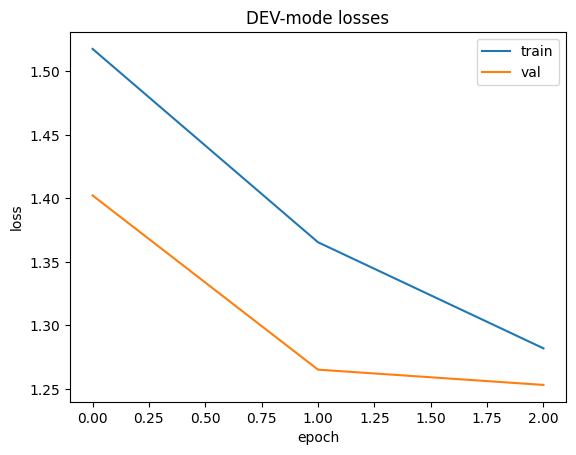

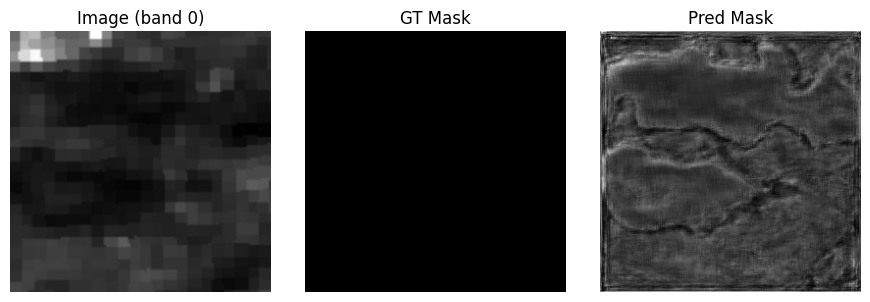

In [12]:
import pickle
import matplotlib.pyplot as plt
from itertools import islice

# 1) helpers to shrink loader
def small_loader(loader, max_batches=20):
    return islice(loader, max_batches)

# 2) containers for logging
train_losses, val_losses = [], []
best_val = float('inf')

# 3) dev run: just 3 “mini-epochs”
DEV_EPOCHS = 3
for epoch in range(1, DEV_EPOCHS+1):
    # 3a) train on first 20 batches only
    tr = train_one_epoch(model, small_loader(train_loader, 20),
                         optim, device)
    # 3b) validate on first 5 batches
    va = validate_one_epoch(model, small_loader(val_loader, 5),
                            device)

    train_losses.append(tr); val_losses.append(va)
    print(f"[DEV] E{epoch} → train={tr:.4f}, val={va:.4f}"
          + (" ← new best!" if va<best_val else ""))

    # 3c) checkpoint best
    if va < best_val:
        best_val = va
        torch.save(model.state_dict(), 'dev_best.pth')

# 4) save logs so you don’t have to re-run dev again
with open('dev_logs.pkl','wb') as f:
    pickle.dump((train_losses, val_losses), f)

# 5) plot the small-epoch curves
plt.plot(train_losses, label='train')
plt.plot(val_losses,   label='val')
plt.title("DEV-mode losses")
plt.xlabel("epoch"); plt.ylabel("loss")
plt.legend(); plt.show()

# 6) load best dev checkpoint & quick sample output
model.load_state_dict(torch.load('dev_best.pth', map_location=device))
model.eval()
imgs, masks = next(iter(val_loader))       # full loader OK now
imgs = imgs.to(device)
with torch.no_grad():
    preds = torch.sigmoid(model(imgs))

# show first image, mask & pred
plt.figure(figsize=(9,3))
plt.subplot(1,3,1)
plt.imshow(imgs[0,0].cpu(), cmap='gray')
plt.title("Image (band 0)")
plt.axis('off')
plt.subplot(1,3,2)
plt.imshow(masks[0,0], cmap='gray')
plt.title("GT Mask")
plt.axis('off')
plt.subplot(1,3,3)
plt.imshow(preds[0,0].cpu(), cmap='gray')
plt.title("Pred Mask")
plt.axis('off')
plt.tight_layout()
plt.show()

## Actual Training Loop
This is the main training loop where the whole training takes place. 20 epochs trained and models are saved at checkpoints (in case of interruptions).
The code is designed to be fail-safe and tells us the results we need at the end of this execution.

In [14]:
#mount drive

from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


[E01] train=1.0201, val=0.9971, seg_f1=0.7115 (thresh=0.50), seg_prec=0.7221, seg_rec=0.7013, det_f1=0.8685 (91.6s)
--> Saved best model with Segmentation F1: 0.7115 (at threshold 0.50) to /content/drive/My Drive/LandslideDetection/Ensemble_Models/Resnet_UNet_BestSegF1_SpecificThresholds


[E02] train=0.9986, val=0.9862, seg_f1=0.7198 (thresh=0.50), seg_prec=0.7532, seg_rec=0.6893, det_f1=0.8797 (91.8s)
--> Saved best model with Segmentation F1: 0.7198 (at threshold 0.50) to /content/drive/My Drive/LandslideDetection/Ensemble_Models/Resnet_UNet_BestSegF1_SpecificThresholds


[E03] train=0.9863, val=0.9811, seg_f1=0.7261 (thresh=0.50), seg_prec=0.7475, seg_rec=0.7060, det_f1=0.8829 (92.2s)
--> Saved best model with Segmentation F1: 0.7261 (at threshold 0.50) to /content/drive/My Drive/LandslideDetection/Ensemble_Models/Resnet_UNet_BestSegF1_SpecificThresholds


[E04] train=0.9854, val=0.9772, seg_f1=0.7282 (thresh=0.50), seg_prec=0.7366, seg_rec=0.7200, det_f1=0.9111 (92.2s)
--> Saved best model with Segmentation F1: 0.7282 (at threshold 0.50) to /content/drive/My Drive/LandslideDetection/Ensemble_Models/Resnet_UNet_BestSegF1_SpecificThresholds


[E05] train=0.9815, val=0.9744, seg_f1=0.7332 (thresh=0.50), seg_prec=0.7629, seg_rec=0.7056, det_f1=0.9119 (92.4s)
--> Saved best model with Segmentation F1: 0.7332 (at threshold 0.50) to /content/drive/My Drive/LandslideDetection/Ensemble_Models/Resnet_UNet_BestSegF1_SpecificThresholds


[E06] train=0.9799, val=0.9742, seg_f1=0.7356 (thresh=0.50), seg_prec=0.7733, seg_rec=0.7014, det_f1=0.8918 (92.8s)
--> Saved best model with Segmentation F1: 0.7356 (at threshold 0.50) to /content/drive/My Drive/LandslideDetection/Ensemble_Models/Resnet_UNet_BestSegF1_SpecificThresholds


[E07] train=0.9774, val=0.9734, seg_f1=0.7507 (thresh=0.30), seg_prec=0.7365, seg_rec=0.7655, det_f1=0.9031 (93.0s)
--> Saved best model with Segmentation F1: 0.7507 (at threshold 0.30) to /content/drive/My Drive/LandslideDetection/Ensemble_Models/Resnet_UNet_BestSegF1_SpecificThresholds


[E08] train=0.9762, val=0.9722, seg_f1=0.7458 (thresh=0.50), seg_prec=0.7040, seg_rec=0.7928, det_f1=0.8835 (93.3s)


[E09] train=0.9767, val=0.9710, seg_f1=0.7524 (thresh=0.50), seg_prec=0.7410, seg_rec=0.7642, det_f1=0.9052 (93.4s)
--> Saved best model with Segmentation F1: 0.7524 (at threshold 0.50) to /content/drive/My Drive/LandslideDetection/Ensemble_Models/Resnet_UNet_BestSegF1_SpecificThresholds


[E10] train=0.9748, val=0.9713, seg_f1=0.7459 (thresh=0.50), seg_prec=0.7984, seg_rec=0.6999, det_f1=0.9058 (93.5s)


[E11] train=0.9746, val=0.9693, seg_f1=0.7590 (thresh=0.50), seg_prec=0.7733, seg_rec=0.7452, det_f1=0.9053 (92.4s)
--> Saved best model with Segmentation F1: 0.7590 (at threshold 0.50) to /content/drive/My Drive/LandslideDetection/Ensemble_Models/Resnet_UNet_BestSegF1_SpecificThresholds


[E12] train=0.9707, val=0.9699, seg_f1=0.7486 (thresh=0.50), seg_prec=0.7878, seg_rec=0.7131, det_f1=0.9162 (92.6s)


[E13] train=0.9708, val=0.9694, seg_f1=0.7583 (thresh=0.50), seg_prec=0.7712, seg_rec=0.7458, det_f1=0.9116 (93.0s)


[E14] train=0.9721, val=0.9682, seg_f1=0.7624 (thresh=0.50), seg_prec=0.7833, seg_rec=0.7427, det_f1=0.9155 (92.7s)
--> Saved best model with Segmentation F1: 0.7624 (at threshold 0.50) to /content/drive/My Drive/LandslideDetection/Ensemble_Models/Resnet_UNet_BestSegF1_SpecificThresholds


[E15] train=0.9702, val=0.9708, seg_f1=0.7607 (thresh=0.30), seg_prec=0.7693, seg_rec=0.7523, det_f1=0.9149 (92.6s)


[E16] train=0.9705, val=0.9680, seg_f1=0.7639 (thresh=0.50), seg_prec=0.7748, seg_rec=0.7532, det_f1=0.9192 (92.5s)
--> Saved best model with Segmentation F1: 0.7639 (at threshold 0.50) to /content/drive/My Drive/LandslideDetection/Ensemble_Models/Resnet_UNet_BestSegF1_SpecificThresholds


[E17] train=0.9691, val=0.9676, seg_f1=0.7633 (thresh=0.50), seg_prec=0.7970, seg_rec=0.7323, det_f1=0.9122 (92.6s)


[E18] train=0.9721, val=0.9682, seg_f1=0.7621 (thresh=0.50), seg_prec=0.7838, seg_rec=0.7416, det_f1=0.9164 (92.6s)


[E19] train=0.9714, val=0.9681, seg_f1=0.7633 (thresh=0.50), seg_prec=0.7695, seg_rec=0.7572, det_f1=0.9133 (93.8s)


[E20] train=0.9709, val=0.9685, seg_f1=0.7645 (thresh=0.50), seg_prec=0.7481, seg_rec=0.7815, det_f1=0.9142 (94.1s)
--> Saved best model with Segmentation F1: 0.7645 (at threshold 0.50) to /content/drive/My Drive/LandslideDetection/Ensemble_Models/Resnet_UNet_BestSegF1_SpecificThresholds


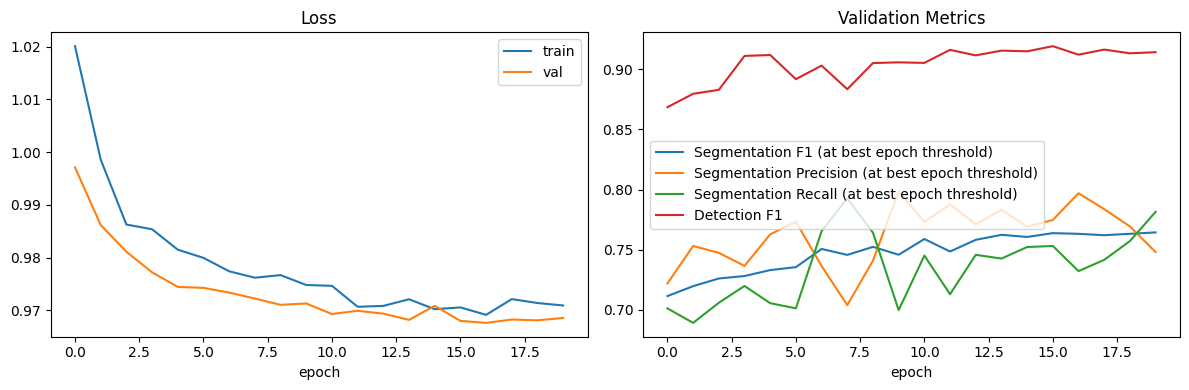

In [15]:
import time
import numpy as np
import torch
from sklearn.metrics import precision_score, recall_score, f1_score
from tqdm import tqdm
import matplotlib.pyplot as plt
import os

# ─── A) CONFIG ────────────────────────────────────────────────
NUM_EPOCHS = 20
thresholds = [0.3, 0.5, 0.9]  # Define specific thresholds to check

train_losses = []
val_losses = []
val_seg_f1s_at_best_thresh, val_seg_precs_at_best_thresh, val_seg_recs_at_best_thresh = [], [], []
val_det_f1s = [] # To store detection F1 scores
best_f1_overall = -1.0  # Initialize best segmentation F1 score overall
best_threshold_overall = -1.0 # Initialize the threshold that gave the best segmentation F1 overall


# ─── B) TRAINING LOOP ─────────────────────────────────────────
for epoch in range(1, NUM_EPOCHS+1):
    start = time.time()

    # --- TRAIN ---
    model.train()
    running_loss = 0.0
    for imgs, masks in tqdm(train_loader, desc=f"[E{epoch:02d}] Train", leave=False):
        imgs, masks = imgs.to(device), masks.to(device)
        optim.zero_grad()
        logits = model(imgs)
        loss = combined_loss(logits, masks)
        loss.backward()
        optim.step()
        running_loss += loss.item() * imgs.size(0)
    train_loss = running_loss / len(train_loader.dataset)
    train_losses.append(train_loss)

    # --- VALIDATE ---
    model.eval()
    running_loss = 0.0
    y_true_seg, y_prob_seg = [], [] # For segmentation metrics
    y_true_det, y_pred_det = [], [] # For detection metrics

    with torch.no_grad():
        for imgs, masks in tqdm(val_loader, desc=f"[E{epoch:02d}] Val", leave=False):
            imgs, masks = imgs.to(device), masks.to(device)
            logits = model(imgs)
            loss = combined_loss(logits, masks)
            running_loss += loss.item() * imgs.size(0)

            probs = torch.sigmoid(logits) # Probabilities for segmentation
            probs_np = probs.cpu().numpy()
            masks_np = masks.cpu().numpy().astype(int)

            # Flatten for segmentation metrics
            y_prob_seg.append(probs_np.ravel())
            y_true_seg.append(masks_np.ravel())

            # Image-level true labels for detection: 1 if mask contains any landslide pixel, 0 otherwise
            y_true_det.extend([1 if np.sum(m) > 0 else 0 for m in masks_np])

            # Image-level predicted labels for detection (using a default threshold for now, will refine later):
            # If any pixel probability in the image exceeds 0.5, predict landslide (1), otherwise no landslide (0)
            y_pred_det.extend([1 if np.max(p) > 0.5 else 0 for p in probs_np]) # Using 0.5 threshold for detection for now


    val_loss = running_loss / len(val_loader.dataset)
    val_losses.append(val_loss)

    y_true_seg = np.concatenate(y_true_seg)
    y_prob_seg = np.concatenate(y_prob_seg)

    # --- Calculate Segmentation Metrics for specified thresholds and find the best F1 for the epoch ---
    best_epoch_seg_f1 = -1.0
    best_threshold_epoch = -1.0
    epoch_seg_prec_at_best_thresh = -1.0
    epoch_seg_rec_at_best_thresh = -1.0

    for threshold in thresholds:
        y_pred_seg = (y_prob_seg > threshold).astype(int)
        seg_f1 = f1_score(y_true_seg, y_pred_seg, zero_division=0)
        seg_prec = precision_score(y_true_seg, y_pred_seg, zero_division=0)
        seg_rec = recall_score(y_true_seg, y_pred_seg, zero_division=0)


        if seg_f1 > best_epoch_seg_f1:
            best_epoch_seg_f1 = seg_f1
            best_threshold_epoch = threshold
            epoch_seg_prec_at_best_thresh = seg_prec
            epoch_seg_rec_at_best_thresh = seg_rec

    val_seg_f1s_at_best_thresh.append(best_epoch_seg_f1)
    val_seg_precs_at_best_thresh.append(epoch_seg_prec_at_best_thresh)
    val_seg_recs_at_best_thresh.append(epoch_seg_rec_at_best_thresh)

    # --- Calculate Detection F1 Score ---
    det_f1 = f1_score(y_true_det, y_pred_det, zero_division=0)
    val_det_f1s.append(det_f1)


    print(f"[E{epoch:02d}] train={train_loss:.4f}, val={val_loss:.4f}, "
          f"seg_f1={best_epoch_seg_f1:.4f} (thresh={best_threshold_epoch:.2f}), seg_prec={epoch_seg_prec_at_best_thresh:.4f}, seg_rec={epoch_seg_rec_at_best_thresh:.4f}, det_f1={det_f1:.4f} ({time.time()-start:.1f}s)")

    # Save best model based on Segmentation F1 score across all epochs and specified thresholds
    if best_epoch_seg_f1 > best_f1_overall:
        best_f1_overall = best_epoch_seg_f1
        best_threshold_overall = best_threshold_epoch
        model_save_dir = "/content/drive/My Drive/LandslideDetection/Ensemble_Models"
        os.makedirs(model_save_dir, exist_ok=True) # Create the directory if it doesn't exist
        model_save_path = os.path.join(model_save_dir, "Resnet_UNet_BestSegF1_SpecificThresholds") # Use correct Loss function name and join path
        torch.save(model.state_dict(), model_save_path)
        print(f"--> Saved best model with Segmentation F1: {best_f1_overall:.4f} (at threshold {best_threshold_overall:.2f}) to {model_save_path}")


plt.figure(figsize=(12,4))

plt.subplot(1,2,1)
plt.plot(train_losses, label="train")
plt.plot(val_losses,   label="val")
plt.title("Loss")
plt.xlabel("epoch")
plt.legend()

plt.subplot(1,2,2)
plt.plot(val_seg_f1s_at_best_thresh,   label="Segmentation F1 (at best epoch threshold)")
plt.plot(val_seg_precs_at_best_thresh, label="Segmentation Precision (at best epoch threshold)")
plt.plot(val_seg_recs_at_best_thresh,  label="Segmentation Recall (at best epoch threshold)")
plt.plot(val_det_f1s, label="Detection F1") # Plot detection F1
plt.title("Validation Metrics")
plt.xlabel("epoch")
plt.legend()

plt.tight_layout()
plt.show()

# Task
Add threshold sweeping to the training process, save the best model based on F1 score as "ResNet_(Loss Function)_Unet++" in the parent directory's "outputs" folder, and prepare the results for presentation.

## Add threshold sweeping

### Subtask:
Modify the training loop to calculate and track the F1 score at different thresholds.


**Reasoning**:
I need to modify the validation loop to calculate and track F1 scores across a range of thresholds and identify the best F1 score and its corresponding threshold for each epoch.

